In [1]:
%load_ext lab_black

In [2]:
import joblib
import logging
import matplotlib.pyplot as plt
import numpy as np
import os

os.chdir("/cerea_raid/users/dumontj/dev/coco2/inv")
import pandas as pd
import pickle
import seaborn as sns
import sys
import tensorflow as tf
import wandb
import xarray as xr
from dataclasses import dataclass, field
from hydra import compose, initialize

from cmcrameri import cm
from hydra.utils import call, instantiate
from icecream import ic
from matplotlib_functions import setMatplotlibParam
from rich.progress import Progress

from mpl_toolkits.axes_grid1 import make_axes_locatable
from omegaconf import DictConfig, OmegaConf
from sklearn import preprocessing
from tensorflow import keras
from typing import List, Optional
from wandb.keras import WandbCallback, WandbMetricsLogger
import polars as pl
import include.callbacks as callbacks
import include.generators as generators
import include.loss as loss
import include.optimisers as optimisers
import model_eval
import models.reg as rm
from Data import Data_eval, Data_train
from include.callbacks import ExtraValidation, get_modelcheckpoint, initiate_wb
from include.generators import InvDataGen
from model_training import Model_training_manager, Trainer
from models.preprocessing import CloudsLayer, ConditionalNoiseLayer
from saver import Saver
import importlib
import matplotlib_functions as mympf

setMatplotlibParam()
plt.viridis()

sys.path.append("/cerea_raid/users/dumontj/dev/coco2/data_build/vis")
import plot_PS

import plotly.express as px
import plotly.io as pio

pio.renderers.default = "notebook"
plt.viridis()
dir_plots = "/cerea_raid/users/dumontj/dev/coco2/inv/notebooks/paper3/"
dir_res = "/libre/dumontj/coco2/weights/new"
dir_ds = "/libre/dumontj/coco2/dl-input"

2024-06-15 16:30:27.907708: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-15 16:30:27.945765: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 16:30:27.945800: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 16:30:27.945827: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-15 16:30:27.953394: I tensorflow/core/platform/cpu_feature_g

<Figure size 1920x1440 with 0 Axes>

In [3]:
tf.random.set_seed(10)

In [4]:
name_model = "inv_oco3_32_sweep/3"
oco3_nc = os.path.join(dir_ds, "oco3/dataset.nc")

In [5]:
df_oco3 = pl.read_parquet(
    "/cerea_raid/users/dumontj/dev/coco2/data_build/preproc_oco3/oco3_images.parquet"
)

In [6]:
data = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model), oco3_nc, cloud_threshold=0.99
)
model = model_eval.get_inversion_model(
    os.path.join(dir_res, name_model), name_w="w_last.h5"
)

2024-06-15 16:30:35.117861: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
ic| self.eval.shape: (39, 32, 32, 3)


In [7]:
inv_eval = model_eval.InversionModelEvaluation(model=model, data=data)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

mae: 7.0235095
mape: 51.312557


In [8]:
def integrated_gradients(model, img_tensor, baseline_tensor, num_steps=100):
    # Define the path from baseline to input as a straight line
    alphas = tf.linspace(start=0.0, stop=1.0, num=num_steps + 1)

    # Compute the gradients of the model's output with respect to the input
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
    grads = tape.gradient(predictions, img_tensor)

    # Compute the gradient at each point along the path
    interpolated_inputs = [
        (baseline_tensor + alpha * (img_tensor - baseline_tensor)) for alpha in alphas
    ]
    interpolated_inputs = tf.stack(interpolated_inputs)
    interpolated_inputs = tf.reshape(
        interpolated_inputs, [-1] + list(img_tensor.shape[1:])
    )
    with tf.GradientTape() as tape:
        tape.watch(interpolated_inputs)
        interpolated_predictions = model(interpolated_inputs)
    interpolated_grads = tape.gradient(interpolated_predictions, interpolated_inputs)

    # Approximate the integral using the trapezoidal rule
    avg_grads = tf.reduce_mean(interpolated_grads, axis=0)
    # integrated_grads = tf.reduce_sum(avg_grads * (img_tensor - baseline_tensor), axis=0)
    return avg_grads

In [9]:
def get_integ_grad(data: Data_eval, idx: int = None):
    if not idx:
        idx = np.random.choice(data.ds.attrs["N_img"])
    x = tf.cast(data.x.eval[idx : idx + 1], tf.float32)
    baseline_tensor = tf.zeros_like(x)
    integ_grad = integrated_gradients(model, x, baseline_tensor).numpy()
    return integ_grad

In [10]:
list_integ_grad = []
list_idx = np.arange(39)

for idx in list_idx:
    list_integ_grad.append(get_integ_grad(data, idx))

In [15]:
def setFigure_4_4(
    pad_w_int_1=0.35,
    pad_w_int_2=0.35,
    pad_w_int_3=0.35,
    pad_h_ext=0.1,
    pad_h_int=0.33,
    projection=None,
):

    wratio = 0.35
    hratio = 0.75
    pad_w_ext = 0.3

    # linewidth
    linewidth = 5.80910486111  # [inch]

    # (w, h) for the ax
    ax_w = wratio * linewidth
    ax_h = hratio * ax_w

    # (w, h) for the figure
    fig_w = 4 * ax_w + 2 * pad_w_ext + pad_w_int_1 + pad_w_int_2 + pad_w_int_3
    fig_h = 4 * ax_h + 2 * pad_h_ext + 3 * pad_h_int

    # (x, y) for the ax
    ax1_x = pad_w_ext / fig_w
    ax2_x = (pad_w_ext + ax_w + pad_w_int_1) / fig_w
    ax3_x = (pad_w_ext + ax_w + pad_w_int_1 + ax_w + pad_w_int_2) / fig_w
    ax4_x = (
        pad_w_ext + ax_w + pad_w_int_1 + ax_w + pad_w_int_2 + ax_w + pad_w_int_3
    ) / fig_w
    ax4_y = pad_h_ext / fig_h
    ax3_y = (pad_h_ext + ax_h + pad_h_int) / fig_h
    ax2_y = (pad_h_ext + ax_h + pad_h_int + ax_h + pad_h_int) / fig_h
    ax1_y = (pad_h_ext + ax_h + pad_h_int + ax_h + pad_h_int + ax_h + pad_h_int) / fig_h
    ax_dx = ax_w / fig_w
    ax_dy = ax_h / fig_h

    # create figure and ax
    figure = plt.figure(figsize=(fig_w, fig_h))
    axs = []
    for ax_y in [ax1_y, ax2_y, ax3_y, ax4_y]:
        for ax_x in [ax1_x, ax2_x, ax3_x, ax4_x]:
            axs.append(
                figure.add_axes([ax_x, ax_y, ax_dx, ax_dy], projection=projection)
            )

    return axs


plt.rcParams["axes.labelsize"] = 10
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8
plt.rcParams["axes.titlesize"] = 10

In [16]:
for idx, source_name in enumerate(df_oco3["source_name"]):
    if source_name == "Tuoketo":
        df_oco3["source_name"][idx] = "Tuoketuo"

In [17]:
for idx_img in range(39):
    if df_oco3[idx_img, "source_name"] == "Tuoketo":
        df_oco3[idx_img, "source_name"] = "Tuoketuo"

/cerea_raid/users/dumontj/dev/coco2/inv/notebooks/paper3/ingenius.png


<Figure size 1920x1440 with 0 Axes>

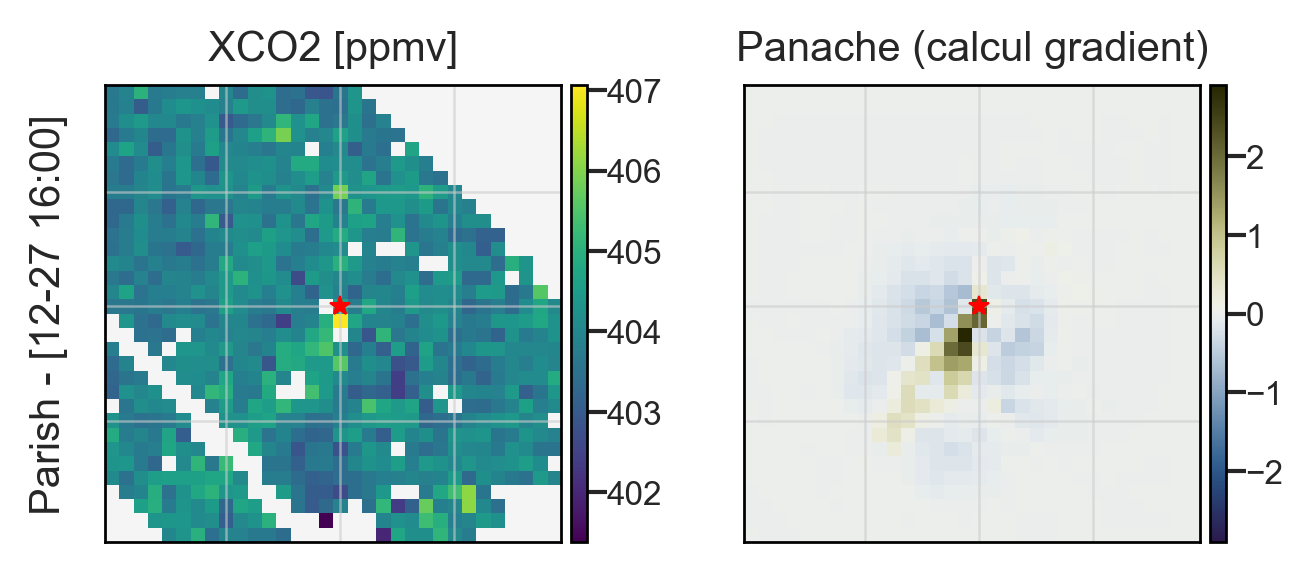

In [25]:
N_idx = 1
N_cols = 2
subfigs = plot_PS.set_subfigs(N_idx, N_cols, 32, 32)
ims = subfigs["ims"]
axs = subfigs["axs"]
cbars = subfigs["cbars"]
caxs = subfigs["caxs"]
list_idx_img = [37]

for i, idx_img in enumerate(list_idx_img):
    # XCO2
    i_ax = 2 * i
    ims[i_ax] = axs[i_ax].imshow(
        np.squeeze(data.x.ds_eval["xco2"][idx_img, :, :]),
        origin="lower",
    )
    caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
    cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")
    axs[i_ax].plot(
        16,
        16,
        marker="*",
        color="red",
        markersize=5,
    )

    # Integ_grad
    i_ax = 2 * i + 1
    integ_grad = np.squeeze(list_integ_grad[idx_img][:, :, 0])
    ims[i_ax] = axs[i_ax].imshow(
        integ_grad,
        cmap="cmc.broc",
        origin="lower",
        vmin=-np.max(np.abs(integ_grad)),
        vmax=np.max(np.abs(integ_grad)),
    )
    caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
    cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")
    axs[i_ax].plot(
        16,
        16,
        marker="*",
        color="red",
        markersize=5,
    )


list_pd_t = []
for idx in list_idx:
    list_pd_t.append(pd.Timestamp(data.ds.sel(idx_img=idx).time.values))

for i, idx_img in enumerate(list_idx_img):
    pd_t_idx = list_pd_t[idx_img]
    axs[2 * i].set_ylabel(
        f"{df_oco3['source_name'][idx_img]} - [{pd_t_idx.month:02d}-{pd_t_idx.day:02d} {pd_t_idx.hour:02d}:00]"
    )
axs[0].set_title("XCO2 [ppmv]", size=10)
axs[1].set_title("Panache (calcul gradient)", size=10)

Ny = int(data.x.eval.shape[1])
Nx = int(data.x.eval.shape[2])
for ax in axs:
    ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
    ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

name_fig = os.path.join(dir_plots, f"ingenius.png")
plt.savefig(name_fig, dpi=300)
print(name_fig)

/cerea_raid/users/dumontj/dev/coco2/inv/notebooks/paper3/integ_grad_big.pdf


<Figure size 1920x1440 with 0 Axes>

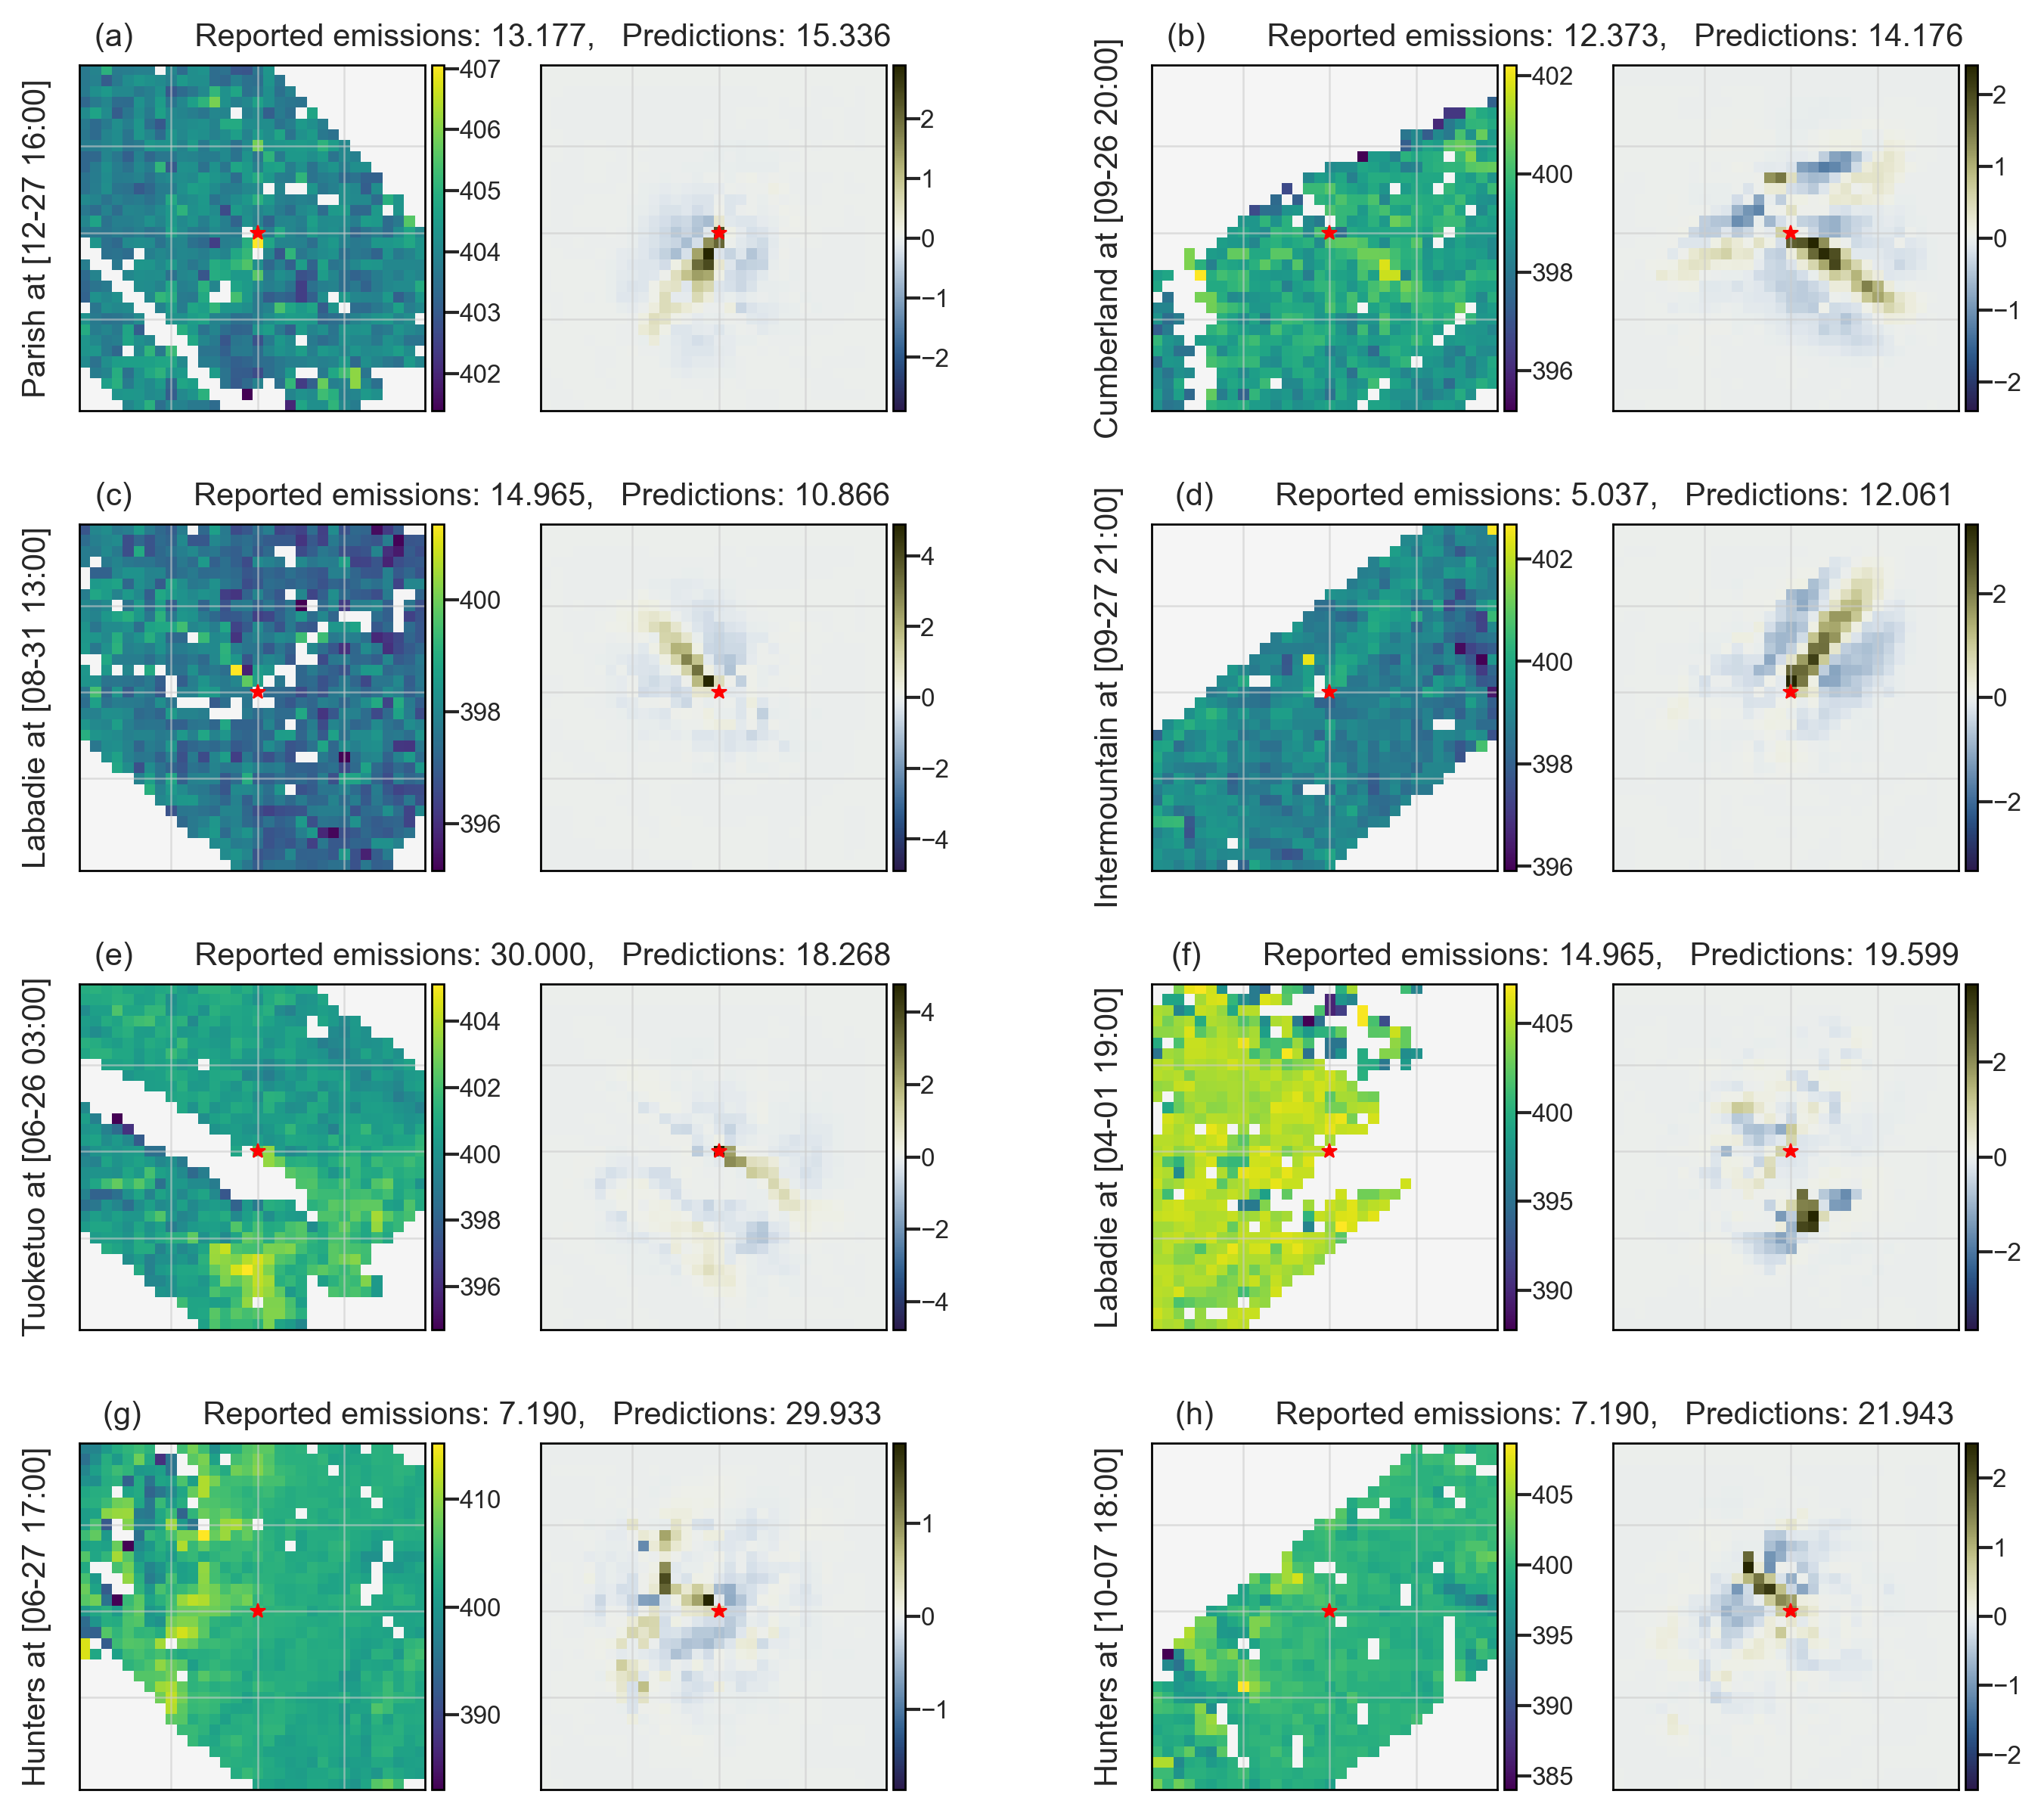

In [18]:
N_idx = 4
N_cols = 4
ims = [None] * (N_idx * N_cols)
caxs = [None] * (N_idx * N_cols)
cbars = [None] * (N_idx * N_cols)


plt.viridis()
axs = setFigure_4_4(
    pad_w_int_1=0.0001,
    pad_w_int_2=0.66,
    pad_w_int_3=0.0001,
    pad_h_int=0.5,
    pad_h_ext=0.3,
)

list_idx_img = [37, 17, 20, 26, 9, 22, 32, 29]

for i, idx_img in enumerate(list_idx_img):
    # XCO2
    i_ax = 2 * i
    ims[i_ax] = axs[i_ax].imshow(
        np.squeeze(data.x.ds_eval["xco2"][idx_img, :, :]),
        origin="lower",
    )
    caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
    cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")
    axs[i_ax].plot(
        16,
        16,
        marker="*",
        color="red",
        markersize=5,
    )

    # Integ_grad
    i_ax = 2 * i + 1
    integ_grad = np.squeeze(list_integ_grad[idx_img][:, :, 0])
    ims[i_ax] = axs[i_ax].imshow(
        integ_grad,
        cmap="cmc.broc",
        origin="lower",
        vmin=-np.max(np.abs(integ_grad)),
        vmax=np.max(np.abs(integ_grad)),
    )
    caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
    cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")
    axs[i_ax].plot(
        16,
        16,
        marker="*",
        color="red",
        markersize=5,
    )


list_pd_t = []
for idx in list_idx:
    list_pd_t.append(pd.Timestamp(data.ds.sel(idx_img=idx).time.values))

for i, idx_img in enumerate(list_idx_img):
    pd_t_idx = list_pd_t[idx_img]
    axs[2 * i].set_ylabel(
        f"{df_oco3['source_name'][idx_img]} at [{pd_t_idx.month:02d}-{pd_t_idx.day:02d} {pd_t_idx.hour:02d}:00]"
    )


list_letters = ["a", "b", "c", "d", "e", "f", "g", "h"]
for i, idx_img in enumerate(list_idx_img):
    axs[1 + 2 * i].set_title(
        f"({list_letters[i]})       "
        f"Reported emissions: {inv_eval.y[idx_img][0]:.3f},   "
        f"Predictions: {inv_eval.pred[idx_img][0]:.3f}   ",
    )
    axs[1 + 2 * i].title.set_position([-0.1, 1.0])

Ny = int(data.x.eval.shape[1])
Nx = int(data.x.eval.shape[2])
for ax in axs:
    ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
    ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

#aname_fig = os.path.join(dir_plots, f"integ_grad_big.pdf")
plt.savefig(name_fig, dpi=300)
print(name_fig)